In [1]:
from dataclasses import dataclass
from collections import deque
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
@dataclass
class Task:
    created_time: float
    service_time: float
    finished_time: float = 0
        
@dataclass
class Channel:
    mu: float
    is_busy: bool = False
    task: Task = None

    def add_request(self, request: Task, current_time: float) -> None:
        self.is_busy = True
        self.task = request
        self.task.finished_time = current_time + self.task.service_time

In [111]:
class QueueingSystem:
    def __init__(self, lm, mu, n, m, p):
        self.lm, self.mu = lm, mu
        self.n, self.m = n, m
        self.p = p
        self.ro = lm/(mu*p) if p and mu else float('inf')
        self.current_time = 0
        self.new_request = None

        self.state_count = []
        self.queue = deque()
        self.channels = []
        self.queue_lengths = []
        self.channels_working = []
        self.tasks_working = []
        self.posterior_state_probs = []

        self.accepted = self.rejected = 0
        self.requests = self.cancelled = 0

    def exp_time(self, lm):
        return -np.log(np.random.uniform()) / lm

    def create_task(self):
        next_request_time = self.current_time + self.exp_time(self.lm)
        processing_time = self.exp_time(self.mu)
        return next_request_time, processing_time

    def start(self, T, dt=0.001):
        self.state_count = np.zeros(self.n + self.m + 1)
        self.channels = [Channel(self.mu) for _ in range(self.n)]
        next_request_time, processing_time = self.create_task()
        self.new_request = Task(
            created_time=next_request_time, service_time=processing_time
        )
        # Modeling
        while self.current_time <= T:
            self.current_time += dt
            self.queue_lengths.append(len(self.queue))
            self.check_system()
            self.generate_task()
        
        # Characteristics
        in_queue = len(self.queue)
        in_channels = self.count_busy_channels()

        print("Всего", self.requests)
        print("Удовлетворено", self.accepted)
        print("Не удовлетворено", self.rejected)
        print("Отказано", self.cancelled)
        print("Осталось в очереди", in_queue)
        print("Осталось в каналах", in_channels)

        self.state_probs = self.calculate_probs()
        pr_state_prob = self.posterior_state_probs[-1]
        p_reject = self.state_probs[-1]
        print('Практ.:', ''.join(f'{p:.3f}' for p in pr_state_prob))
        print('Теор.:', ''.join(f'{p:.3f}' for p in self.state_probs))

        absolute_throughput = self.throughput(pr_state_prob[-1], p_reject)
        self.cancellation_statistic(p_reject)
        av_queue_len, pr_av_queue_len = self.average_reqs_queue(self.state_probs)
        av_work_channels, _ = self.average_working_channels(p_reject)
        av_reqs_sys, pr_av_reqs_sys = self.average_reqs_system(av_queue_len, av_work_channels)
        self.average_req_live_sys(av_reqs_sys, absolute_throughput, pr_av_reqs_sys)
        self.average_req_live_queue(av_queue_len, absolute_throughput, pr_av_queue_len)
        
    def count_busy_channels(self):
        return sum(c.is_busy for c in self.channels)

    def check_system(self):
        num_busy_channels = 0
        for channel in self.channels:
            if channel.is_busy and self.current_time >= channel.task.finished_time:
                task = channel.task
                channel.is_busy = False
                channel.task = None
                accept = np.random.choice([True, False], p=[self.p, 1-self.p])
                if accept:
                    self.accepted += 1
                else:
                    self.rejected += 1
                    if len(self.queue) == self.m:
                        self.cancelled += 1
                        return
                    self.queue.append(task)
            
            if not channel.is_busy and len(self.queue):
                request = self.queue.popleft()
                channel.add_request(request, self.current_time)

            if channel.is_busy:
                num_busy_channels += 1

        self.channels_working.append(num_busy_channels)
        num_busy_channels += len(self.queue)
        self.tasks_working.append(num_busy_channels)
        self.state_count[num_busy_channels] += 1

        num_states = sum(self.state_count)
        state_probs = [c / num_states for c in self.state_count]
        self.posterior_state_probs.append(state_probs)

    def generate_task(self):
        if self.current_time >= self.new_request.created_time:
            self.requests += 1
            if len(self.queue) == self.m and self.m:
                self.cancelled += 1
                
            next_request_time, proc_time = self.create_task()
            self.new_request = Task(
                created_time=next_request_time, service_time=proc_time
            )
            for c in self.channels:
                if not c.is_busy:
                    c.add_request(self.new_request, self.current_time)
                    break
            if len(self.queue) < self.m:
                self.queue.append(self.new_request)
        return
                
    
    def throughput(self, ep_reject, tp_reject):
        pr_relative_throughput = self.accepted / self.requests  # 1 - ep_reject
        relative_throughput = 1 - tp_reject
        pr_absolute_throughput = self.lm*pr_relative_throughput
        absolute_throughput = self.lm*relative_throughput
        print(f'Относительная пропускная способность: {pr_relative_throughput:.3f} {relative_throughput:.3f}')
        print(f'Абсолютная пропускная способность: {pr_absolute_throughput:.3f} {absolute_throughput:.3f}')
        return absolute_throughput

    def cancellation_statistic(self, p_reject):
        pr_cancellations = self.cancelled / self.requests
        print(f'Вероятность отказа {pr_cancellations:.3f} {p_reject:.3f}')

    def calculate_probs(self):
        tprobs = np.zeros(self.m + self.n + 1)
        n, m = self.n, self.m
        ro = self.ro
        ksi = ro / n
        if abs(ksi - 1) <= 1e-5:
            print('Warning: ksi = 1!')

        if self.p == 0:
            tprobs[-1] = 1
        else:
            sm = 1
            fact_i = 1
            for i in range(1, n+1):
                fact_i *= i
                sm += ro**i / fact_i
            
            fact_n, fact_i = fact_i, 1
            if abs(ksi - 1) > 1e-5:
                sm += ro**(n+1)*((1-ksi**m)/(1-ksi)) / (fact_n*n) 
            else:
                sm += m*ro**n / fact_n

            p0 = 1 / sm
            tprobs[0] = p0
            for i in range(1, n+1):
                fact_i *= i
                tprobs[i] = ro**i*p0 / fact_i 
                
            fact_n = fact_i
            for i in range(n+1, n+m+1):
                tprobs[i] = ro**i*p0 / (fact_n*n**(i-n))

        return tprobs

    def average_reqs_queue(self, state_probs):
        pract_average = np.mean(self.queue_lengths)
        average = sum(i*state_probs[self.n+i] for i in range(1, self.m+1))
        
        print(f'Среднее число заявок в очереди: {pract_average:.3f} {average:.3f}')
        return average, pract_average

    def average_working_channels(self, p_reject):
        pract_average = np.mean(self.channels_working)
        average = self.ro*(1-p_reject)
        
        print(f'Среднее число занятых каналов: {pract_average:.3f} {average:.3f}')
        return average, pract_average

    def average_reqs_system(self, average_queue, average_channels):
        pract_average = np.mean(self.tasks_working)
        average = average_queue + average_channels
        
        print(f'Среднее число заявок в СМО: {pract_average:.3f} {average:.3f}')
        return average, pract_average

    def average_req_live_sys(self, average_reqs_sys, absolute_throughput, average_reqs_sys_pract):
        pract_average = average_reqs_sys_pract / absolute_throughput
        average = average_reqs_sys / absolute_throughput
        
        print(f'Среднее время пребывания заявки в СМО: {pract_average:.3f} {average:.3f}')
        return pract_average, average

    def average_req_live_queue(self, average_request_queue, absolute_throughput, average_request_queue_pract):
        pract_average = average_request_queue_pract / absolute_throughput
        average = average_request_queue / absolute_throughput
        
        print(f'Среднее время пребывания заявки в очереди: {pract_average:.3f} {average:.3f}')
        return pract_average, average

    def plot_state_dist(self, state_probs):
        _ = plt.figure(figsize=(16, 10))
        size = len(self.posterior_state_probs)
        x = range(size)
        states = range(self.n + self.m + 1)
        for state in states:
            y = [self.posterior_state_probs[t][state] for t in range(size)]
            ty = np.full(size, state_probs[state])
            plt.title('States distrubutions')
            plt.ylabel('p')
            plt.xlabel('iters')
            rgb = np.random.rand(3,)
            plt.plot(x, y, c=rgb, label=f'state{state}')
            plt.plot(x, ty, c=rgb)
            plt.legend(loc="best")
        plt.show()

In [112]:
qs = QueueingSystem(lm=2, mu=2, n=3, m=0, p=0.6)
qs.start(1000)

Всего 2009
Удовлетворено 1127
Не удовлетворено 754
Отказано 754
Осталось в очереди 0
Осталось в каналах 0
Практ.: 0.3590.3900.1890.062
Теор.: 0.2070.3450.2880.160
Относительная пропускная способность: 0.561 0.840
Абсолютная пропускная способность: 1.122 1.680
Вероятность отказа 0.375 0.160
Среднее число заявок в очереди: 0.000 0.000
Среднее число занятых каналов: 0.955 1.400
Среднее число заявок в СМО: 0.955 1.400
Среднее время пребывания заявки в СМО: 0.568 0.833
Среднее время пребывания заявки в очереди: 0.000 0.000


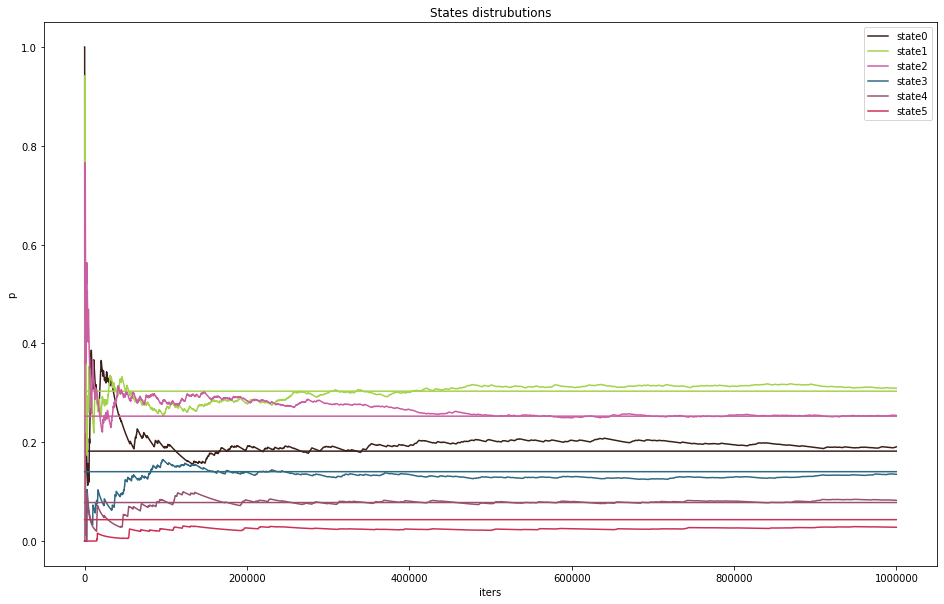

In [43]:
qs.plot_state_dist(qs.state_probs)